In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict, defaultdict
import os
import datetime as dt
import pyfpgrowth;
from efficient_apriori import apriori
from sklearn.cluster import AgglomerativeClustering
datapath = os.getcwd()
from  more_itertools import unique_everseen
log_data_path = datapath + "/data"
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt

In [2]:
datapath

'/Users/apurvakatti/Desktop/cffs-candidates-identification-clustering'

In [3]:
chrome_log = log_data_path + "/Log.txt.access_log.2015"
data = pd.read_csv(chrome_log , sep=" ",header=None,names=["IP","Junk1","Junk2","DateTime","Permission","FilePath","Status","BytesAccessed","Junk3","UserAgent"])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
len(data)

1000000

In [6]:
data=data.head(n=50000)

In [7]:
data=data.drop(['Junk1','Junk2','Junk3'], axis=1)

In [8]:
data['DateTimePermission'] = data['DateTime'].str.cat(data['Permission'])

In [9]:
data=data.drop(['DateTime','Permission'], axis=1)

In [10]:
data['FilePath']=data['FilePath'].str.replace('GET ','')

In [11]:
data['FilePath']=data['FilePath'].str.replace('POST ','')

In [12]:
data['FilePath']=data['FilePath'].str.replace('HEAD ','')

In [13]:
data['FilePath']=data['FilePath'].str.replace(' HTTP/1.1','')

In [14]:
len(data)

50000

In [15]:
'''fout = "/Users/apurvakatti/Desktop/output_10000_hac.txt"
fo = open(fout, "w")
for item in data['FilePath']:
    fo.write(item+'\n')
fo.close()'''

'fout = "/Users/apurvakatti/Desktop/output_10000_hac.txt"\nfo = open(fout, "w")\nfor item in data[\'FilePath\']:\n    fo.write(item+\'\n\')\nfo.close()'

In [16]:
data['DateTimePermission']=data['DateTimePermission'].str.replace('-0400','')

In [17]:
data['DateTimePermission']=data['DateTimePermission'].str.replace('-0500','')

In [18]:
data=data.rename(index=str,columns={"DateTimePermission":"DateTime"})

In [19]:
data=data.sort_values(by=['DateTime'], ascending=True)

In [20]:
data=data.dropna()

In [21]:
data=data.drop(data.index[0])

In [22]:
data=data.drop(['Status'],axis=1)

In [23]:
data['DateTime']=pd.to_datetime(data['DateTime'],format='[%d/%b/%Y:%H:%M:%S]')

In [24]:
data['EpochTime']=pd.DataFrame((data['DateTime'] - dt.datetime(1970,1,1)).dt.total_seconds())

In [25]:
#Generating sessions based on the paper mentioned where we consider the IP address and the useragent
#and create a session by keeping the time window as 15 minutes
#Here if the IP and the user agent are the same within 15 minutes, tehn that transaction belongs to a 
#particular session
datagroupby=data.groupby([pd.cut(data['EpochTime'],
                    np.arange(data['EpochTime'].min(),
                             data['EpochTime'].max(),900)),'IP','UserAgent'])

In [26]:
#Also I am removing all the sessions with less than 2 filepaths in each session and also aviding those sessions
#without any transacrions
dataTempGroupByList=[]
count=0
countsessions=0
for x in datagroupby.groups:
    try:
        datagroupby.get_group(x)
        if(len(datagroupby.get_group(x))>1):
           # print(len(datagroupby.get_group(x)))
            dataTempGroupByList.append(datagroupby.get_group(x)['FilePath'].tolist())
            countsessions=countsessions+1
    except KeyError:
        count=count+1

In [27]:
dataTempGroupByList[0]

['/~shaiduc', '/~shaiduc/']

In [28]:
countsessions

5174

In [29]:
#This is a smaller example of 6*6 matrix considered! Run this for better understanding....
s1=[1,2,3,4,5]
s2=[1,2,3,5,6]
s3=[2,3,4,5]
s4=[3,4]
s5=[3,5,6]
s6=[3,2]
temp_list=[]
temp_list.append(s1)
temp_list.append(s2)
temp_list.append(s3)
temp_list.append(s4)
temp_list.append(s5)
temp_list.append(s6)

In [30]:
temp_list

[[1, 2, 3, 4, 5], [1, 2, 3, 5, 6], [2, 3, 4, 5], [3, 4], [3, 5, 6], [3, 2]]

In [31]:
#Here the similarity matrix is constructed based on the subset method which is when we compare s1 with all others 
#we see if it is a subset, if it is a subset then we move on to find out the length.If not a subset value appended 
#in the similarity matrix is 0.
similarity_matrix=[]
for i in range(0,len(temp_list)):
    temp=list()
    for j in range(0,len(temp_list)):
        if(i==j):
            temp.append(-1)
        else:
            string1=''.join(str(x) for x in temp_list[i])
            string2=''.join(str(x) for x in temp_list[j])
            if( string2 in string1 or string1 in string2):
                if(len(temp_list[i])>len(temp_list[j])):
                    temp.append(len(temp_list[j]))
                else:
                    temp.append(len(temp_list[i]))
            else:
                temp.append(0)
    similarity_matrix.append(temp)

In [32]:
similarity_matrix=np.array(similarity_matrix)

In [33]:
similarity_matrix

array([[-1,  0,  4,  2,  0,  0],
       [ 0, -1,  0,  0,  3,  0],
       [ 4,  0, -1,  2,  0,  0],
       [ 2,  0,  2, -1,  0,  0],
       [ 0,  3,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0, -1]])

In [34]:
import plotly.plotly as py
import plotly.figure_factory as ff
py.plotly.tools.set_credentials_file(username='apurvakatti', api_key='4BJf6cIomCWR19W1vGR5')
import numpy as np

X = similarity_matrix
dendro = ff.create_dendrogram(X)
dendro['layout'].update({'width':800, 'height':500})
py.iplot(dendro, filename='simple_dendrogram')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~apurvakatti/0 or inside your plot.ly account where it is named 'simple_dendrogram'


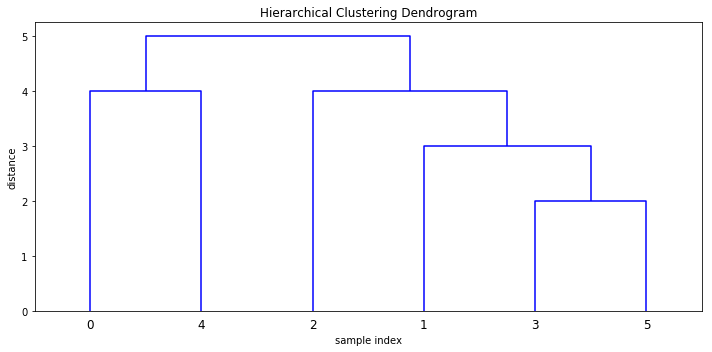

In [35]:
linkage_matrix = linkage(similarity_matrix,'complete',metric='chebyshev',)
figure = plt.figure(figsize=(10,5))
dendrogram(
    linkage_matrix,
    color_threshold=0,
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.tight_layout()
plt.show()

In [36]:
linkage_matrix

array([[3., 5., 2., 2.],
       [1., 6., 3., 3.],
       [0., 4., 4., 2.],
       [2., 7., 4., 4.],
       [8., 9., 5., 6.]])

In [37]:
#Here I am doing the same thing on the sessions
similarity_matrix_temp=[]
for i in range(0,len(dataTempGroupByList)):
    temp=list()
    for j in range(0,len(dataTempGroupByList)):
        if(i==j):
            temp.append(-1)
        else:
            string1=''.join(str(x) for x in dataTempGroupByList[i])
            string2=''.join(str(x) for x in dataTempGroupByList[j])
            if( string2 in string1 or string1 in string2):
                if(len(dataTempGroupByList[i])>len(dataTempGroupByList[j])):
                    temp.append(len(dataTempGroupByList[j]))
                else:
                    temp.append(len(dataTempGroupByList[i]))
            else:
                temp.append(0)
    similarity_matrix_temp.append(temp)

In [38]:
similarity_matrix_temp=np.array(similarity_matrix_temp)

from scipy.cluster import hierarchy
Z = hierarchy.linkage(similarity_matrix_temp, metric='precomputed')
labels = hierarchy.fcluster(Z, n_clusters, criterion='maxclust')

In [39]:
model=AgglomerativeClustering(affinity='precomputed', n_clusters=10, linkage='complete').fit(similarity_matrix_temp)
labels = model.labels_

In [40]:
#labels[997]

In [41]:
#matching the cluster lables to teh filepaths using a dictionary
match_cluster_each_filepath={}
for item,number in zip(dataTempGroupByList,labels):
    for i in item:
        if number in match_cluster_each_filepath:
            match_cluster_each_filepath[number].append(i)
        else:
            match_cluster_each_filepath[number]=[i]

In [42]:
match_cluster_each_filepath

{8: ['/~shaiduc',
  '/~shaiduc/',
  '/~baker/devices/lxr/http/source/linux/fs/ext2/inode.c HTTP/1.0',
  '/~baker/devices/lxr/http/source/linux/fs/xfs/xfs_attr.h HTTP/1.0',
  '/~baker/devices/lxr/http/source/linux/fs/xfs/xfs_buf_item.h HTTP/1.0',
  '/~baker/devices/lxr/http/source/linux/drivers/staging/go7007/go7007.h HTTP/1.0',
  '/~baker/devices/lxr/http/source/linux/drivers/staging/meilhaus/me4600_ao.h HTTP/1.0',
  '/~asriniva/research.html',
  '/~asriniva/index.html',
  '/~asriniva/cv.html',
  '/',
  '/~wingfiel/images/cs_mini.gif',
  '/script/preload.js',
  '/css/index.css',
  '/css/global.css',
  '/~wingfiel/images/bg.gif',
  '/images/facebook.png',
  '/images/recognitions.gif',
  '/images/news.gif',
  '/images/InBug-60px-R.png',
  '/images/cs.gif',
  '/images/research_link.gif',
  '/Scholarship.gif',
  '/images/left_bg.gif',
  '/images/current_link.gif',
  '/images/bottom_bg.gif',
  '/images/bullet.gif',
  '/~wingfiel/images/links_right.gif',
  '/images/search.gif',
  '/images/ar

In [43]:
#Generating the txt file for perl scripts
fout = "/Users/apurvakatti/Desktop/output_from_hac_900sec.txt"
fo = open(fout, "w")

for k, v in match_cluster_each_filepath.items():
    fo.write("Cluster"+" "+str(k)+'\n')
    for key in v:
        fo.write(str(key)+'\n')

fo.close()

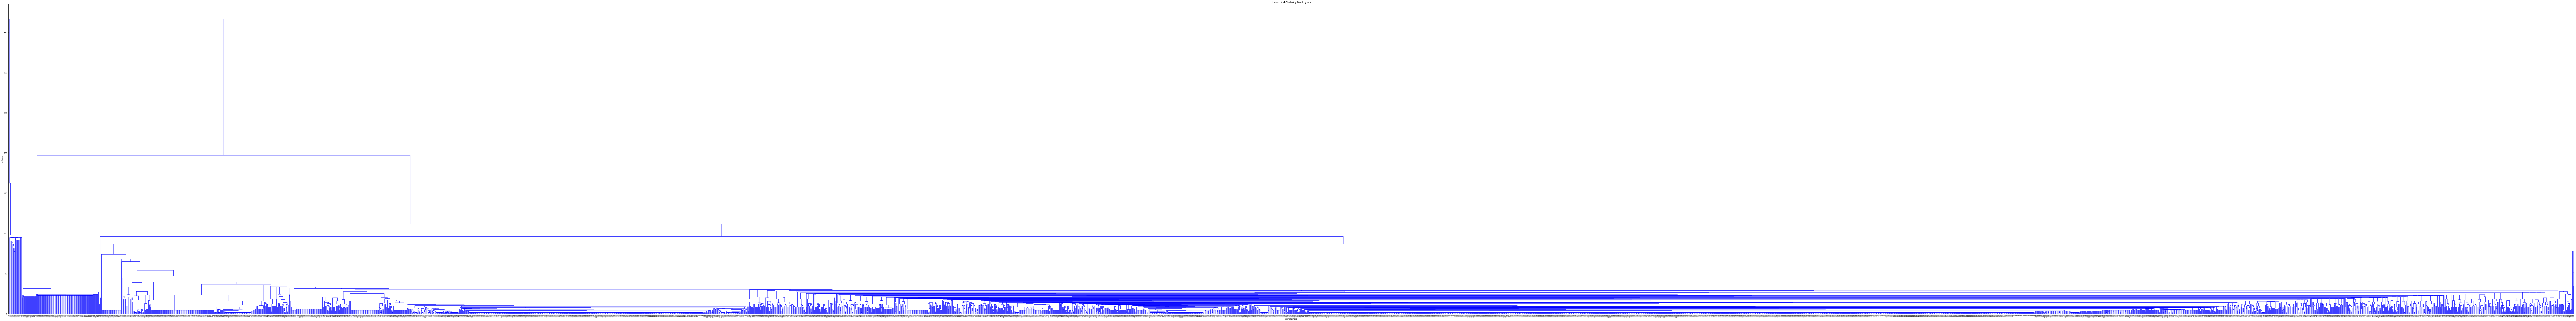

In [44]:
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_matrix = linkage(similarity_matrix_temp, 'complete')
figure = plt.figure(figsize=(200,25))
dendrogram(
    linkage_matrix,
    color_threshold=0,
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.tight_layout()
plt.show()

In [45]:
import plotly.plotly as py
import plotly.figure_factory as ff
py.plotly.tools.set_credentials_file(username='apurvakatti', api_key='4BJf6cIomCWR19W1vGR5')
import numpy as np

X = similarity_matrix_temp
dendro = ff.create_dendrogram(X)
dendro['layout'].update({'width':1500, 'height':500})
py.iplot(dendro, filename='simple_dendrogram')

PlotlyRequestError: 
<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>


In [ ]:
figure = plt.figure(figsize=(7.5, 5))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()